In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Loading the data**

In [ ]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
from os import listdir
from os.path import isfile, join
import re
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
import cv2

x = []
y = []

# New size:
w = 240
h = 320

#Class 0: 0-50%
mypath = '/content/drive/MyDrive/Colab Notebooks/Master Thesis/TN_Training/TN_0' # edit with the path to your data
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]

for file in files:
    label = 0
    y.append(label)
    img = cv2.imread(mypath+'/'+file)
    #img = cv2.GaussianBlur(img,(7,7),0)
    img = cv2.resize(img, dsize=(h, w), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
    x.append(img)


#Class 1: 50-99%
mypath = '/content/drive/MyDrive/Colab Notebooks/Master Thesis/TN_Training/TN_1' # edit with the path to your data
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]

for file in files:
    label = 1
    y.append(label)
    img = cv2.imread(mypath+'/'+file)
    #img = cv2.GaussianBlur(img1,(7,7),0)
    img = cv2.resize(img, dsize=(h, w), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    x.append(img)


#Class 2: 100%
mypath = '/content/drive/MyDrive/Colab Notebooks/Master Thesis/TN_Training/TN_2' # edit with the path to your data
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]

for file in files:
    label = 2
    y.append(label)
    img = cv2.imread(mypath+'/'+file)
    #img = cv2.GaussianBlur(img1,(7,7),0)
    img = cv2.resize(img, dsize=(h, w), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    x.append(img)


x = np.array(x) #containing the NT images
y = np.array(y) #containing the corresponding labels

##no gaussian filter is applied, it worsens the training results

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Model / data parameters
num_classes = 3
input_shape = (h, w, 1)

# the data, split between train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle= True)

y_test_cm = y_test

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (853, 240, 320, 1)
853 train samples
366 test samples


# **Simple CNN: Building and Training the model**

In [ ]:
in_shape = (w,h,1)

model = keras.Sequential(
    [
        keras.Input(shape=in_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 318, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 119, 159, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 157, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 58, 78, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 289536)            0         
                                                                 
 dropout (Dropout)           (None, 289536)            0

**Checking filters of simple CNN**

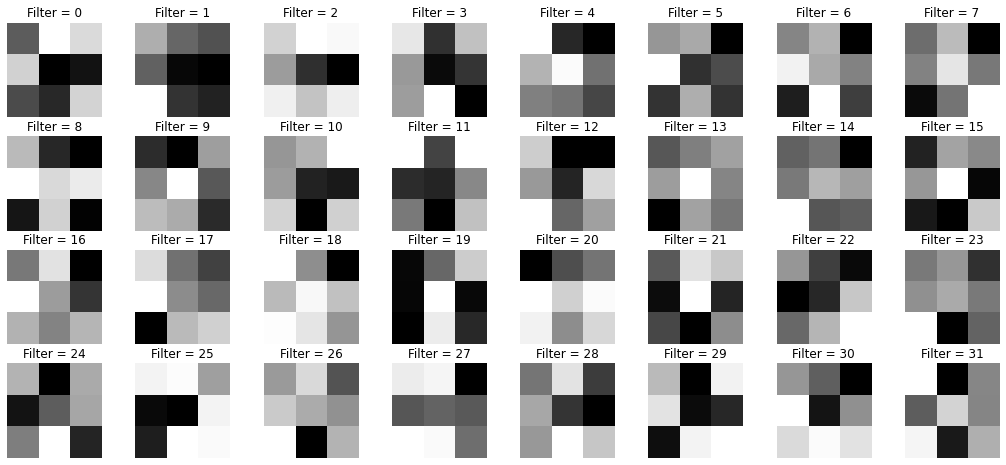

In [ ]:
#first conv. layer

filters, biases = model.layers[0].get_weights()
from matplotlib import pyplot

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

filters.shape
filters1 = filters.squeeze()


import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 8))
for kfilt in range(0,32):
    ax = fig.add_subplot(4, 8, kfilt+1)
    ax.imshow(filters1[:,:,kfilt], cmap='gray') 
    ax.set_title('Filter = {}'.format(kfilt))
    ax.axis('off')

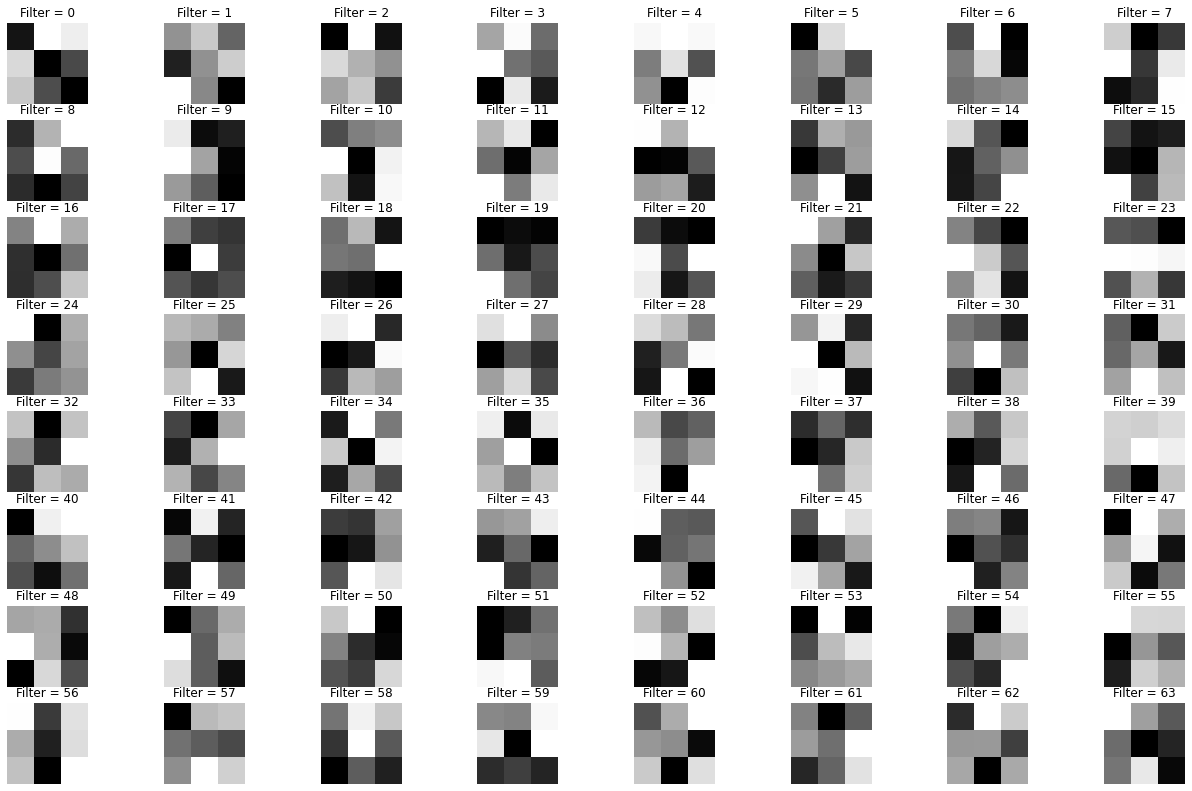

In [ ]:
#second conv. layer

filters, biases = model.layers[2].get_weights()
from matplotlib import pyplot

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

filters.shape
filters1 = filters[:,:,0,:]

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(22, 14))
for kfilt in range(0,64):
    ax = fig.add_subplot(8, 8, kfilt+1)
    ax.imshow(filters1[:,:,kfilt], cmap='gray') 
    ax.set_title('Filter = {}'.format(kfilt))
    ax.axis('off')

In [ ]:
batch_size = 20

epochs = 10

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

model.save('/content/drive/MyDrive/Colab Notebooks/Master Thesis/NT models') #save the model

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


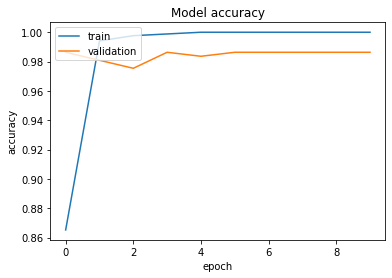

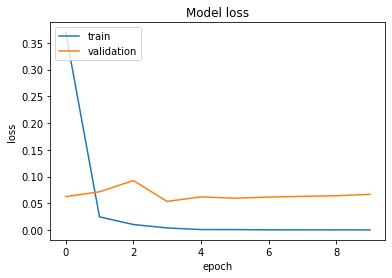

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'validation'], loc='upper left')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#load the model again
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Master Thesis/NT models')

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.04430396854877472
Test accuracy: 0.9890710115432739


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       134
           1       0.99      0.97      0.98       103
           2       0.99      1.00      1.00       129

    accuracy                           0.99       366
   macro avg       0.99      0.99      0.99       366
weighted avg       0.99      0.99      0.99       366



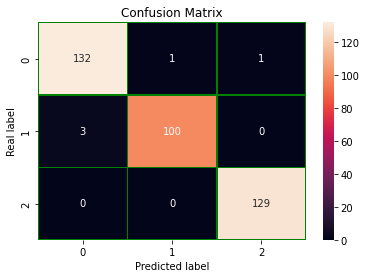

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_test_pred =  np.argmax(model.predict(x_test), axis=-1)

cm = confusion_matrix(y_test_cm,y_test_pred)

sns.heatmap(cm, annot=True, linewidths=0.5, linecolor='green', fmt='.0f')
plt.xlabel('Predicted label')
plt.ylabel('Real label')
plt.title('Confusion Matrix')


target_names = ['0','1','2']
print(classification_report(y_test_cm, y_test_pred, target_names=target_names))

In [ ]:
np.where(y_test_cm ==2)

(array([  1,   4,   8,  11,  12,  14,  15,  17,  22,  23,  34,  36,  41,
         42,  43,  44,  45,  46,  49,  53,  54,  55,  57,  58,  59,  60,
         61,  62,  64,  65,  70,  71,  72,  77,  80,  81,  85,  87,  91,
         93,  97,  99, 107, 108, 110, 111, 120, 125, 127, 129, 131, 132,
        133, 135, 137, 138, 140, 141, 142, 146, 150, 154, 156, 157, 159,
        161, 164, 168, 169, 170, 179, 181, 184, 186, 187, 192, 194, 195,
        196, 197, 203, 205, 208, 213, 219, 223, 225, 226, 237, 240, 242,
        243, 256, 262, 263, 264, 266, 269, 273, 274, 275, 277, 283, 284,
        288, 292, 297, 300, 302, 303, 304, 306, 312, 315, 316, 322, 323,
        324, 326, 328, 329, 330, 331, 332, 334, 336, 342, 349, 350, 351,
        356, 363, 364]),)

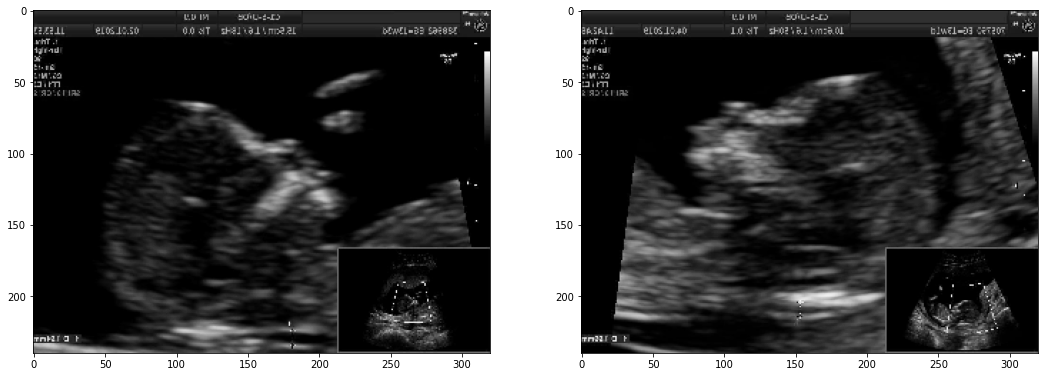

In [ ]:
image_g = x_test[8].reshape(240,320)
image_g2 = x_test[11].reshape(240,320)

fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(image_g, cmap='gray') 
#ax.set_title('img1: '+ str(image_titles[0]))
ax = fig.add_subplot(1, 2, 2)
ax.imshow(image_g2, cmap='gray') 
#ax.set_title('img2: '+ str(image_titles[1]))
plt.show()

# **Checking misclassified images**

In [ ]:
np.where((y_test_cm == 0)&(y_test_pred == 1)) #these images have the label 0 (worst class) but were classified as 1

(array([296]),)

In [ ]:
image1 = x_test[139].reshape(240,320)
image2 = x_test[309].reshape(240,320)
image3 = x_test[365].reshape(240,320)

fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(image1, cmap='gray') 
#ax.set_title('img1: '+ str(image_titles[0]))
ax = fig.add_subplot(1, 3, 2)
ax.imshow(image2, cmap='gray') 
#ax.set_title('img2: '+ str(image_titles[1]))
ax = fig.add_subplot(1,3, 3)
ax.imshow(image3, cmap='gray') 
#ax.set_title('img3: ' + str(image_titles[2]))
plt.show()

# **DL Interpretability: GradCam**

In [ ]:
!pip install tf_keras_vis tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.7 MB/s 


In [ ]:
import tensorflow as tf

def model_modifier(current_model):
    current_model.layers[-1].activation = tf.keras.activations.linear
    return current_model

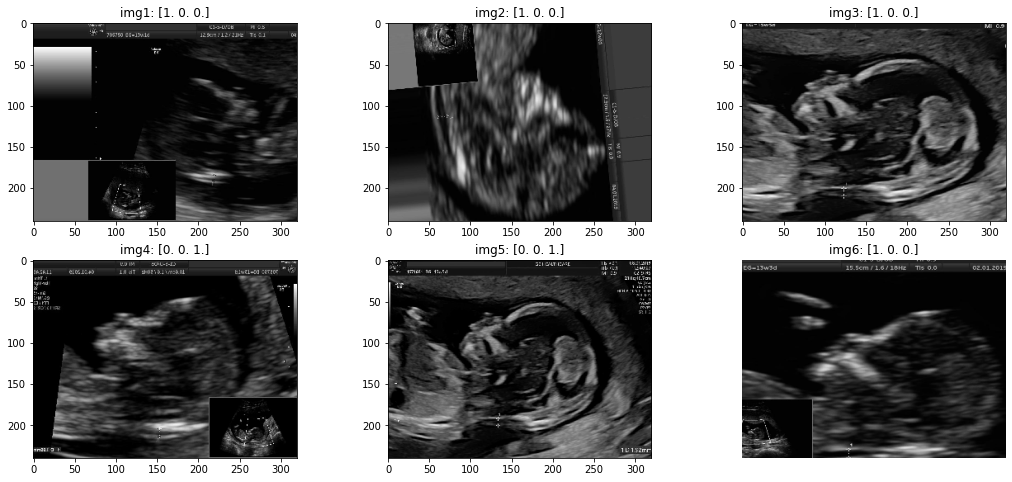

In [ ]:
# Image titles
image_titles = [y_test[0], y_test[1], y_test[6], y_test[7], y_test[8], y_test[9]]

# Load images and Convert them to a Numpy array
img1 = x_test[0].reshape(240,320)
img2 = x_test[1].reshape(240,320)
img3 = x_test[6].reshape(240,320)
img4 = x_test[7].reshape(240,320)
img5 = x_test[8].reshape(240,320)
img6 = x_test[9].reshape(240,320)

fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(2, 3, 1)
ax.imshow(img1, cmap='gray') 
ax.set_title('img1: '+ str(image_titles[0]))
ax = fig.add_subplot(2, 3, 2)
ax.imshow(img2, cmap='gray') 
ax.set_title('img2: '+ str(image_titles[1]))
ax = fig.add_subplot(2,3, 3)
ax.imshow(img3, cmap='gray') 
ax.set_title('img3: ' + str(image_titles[2]))
ax = fig.add_subplot(2,3, 4)
ax.imshow(img4, cmap='gray') 
ax.set_title('img4: ' + str(image_titles[3]))
ax = fig.add_subplot(2,3, 5)
ax.imshow(img5, cmap='gray') 
ax.set_title('img5: ' + str(image_titles[4]))
ax = fig.add_subplot(2,3, 6)
ax.imshow(img6, cmap='gray') 
ax.set_title('img6: ' + str(image_titles[5]))
ax.axis('off')
plt.show()

In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

images = np.asarray([np.array(img1), np.array(img2), np.array(img3),np.array(img4),np.array(img5),np.array(img6)])
X = images.reshape(6,240,320,1)

#images = [np.array(img1), np.array(img2), np.array(img3), np.array(img4), np.array(img5), np.array(img6)]

title1 = np.argmax(y_test[0])
title2 = np.argmax(y_test[1])
title3 = np.argmax(y_test[6])
title4 = np.argmax(y_test[7])
title5 = np.argmax(y_test[8])
title6 = np.argmax(y_test[9])

image_titles = [title1, title2, title3, title4, title5, title6]

score = CategoricalScore([title1, title2, title3, title4, title5, title6])

#Create Gradcam object
gradcam = Gradcam(model,model_modifier=model_modifier,clone=False)

#Generate heatmap with GradCAM
cam = gradcam(score, X, penultimate_layer=-1)
#cam = gradcam(score, X, penultimate_layer=-1)

#Render
f, ax = plt.subplots(nrows=1, ncols=6, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(heatmap, cmap='jet', alpha=1) #overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

**NEW IMAGES**

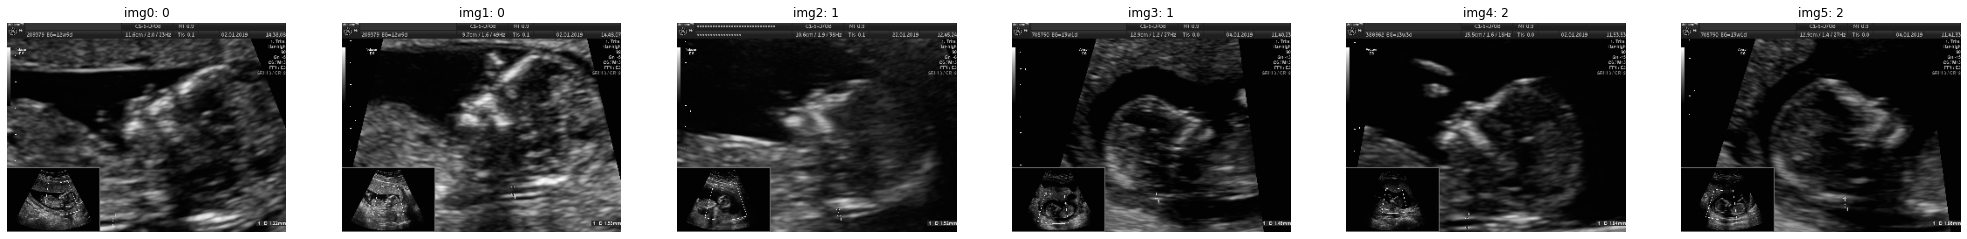

In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
import cv2
import numpy as np
import matplotlib.pyplot as plt

#Load the images
test_img0 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Master Thesis/Ultrasound_fetus/NT_new/NT_0/TN_0_1/94476745.jpg')
test_img0 = cv2.resize(test_img0, dsize=(h, w), interpolation=cv2.INTER_CUBIC)
test_img0 = cv2.cvtColor(test_img0, cv2.COLOR_BGR2GRAY)
test_img1 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Master Thesis/Ultrasound_fetus/NT_new/NT_0/TN_0_1/94476841.jpg')
test_img1 = cv2.resize(test_img1, dsize=(h, w), interpolation=cv2.INTER_CUBIC)
test_img1 = cv2.cvtColor(test_img1, cv2.COLOR_BGR2GRAY)
test_img2 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Master Thesis/Ultrasound_fetus/NT_new/NT_1/TN_1_1/34343434.jpg')
test_img2 = cv2.resize(test_img2, dsize=(h, w), interpolation=cv2.INTER_CUBIC)
test_img2 = cv2.cvtColor(test_img2, cv2.COLOR_BGR2GRAY)
#test_img2 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Master Thesis/Ultrasound_fetus/NT_new/NT_1/TN_1_1/94592386.jpg')
#test_img2 = cv2.resize(test_img2, dsize=(h, w), interpolation=cv2.INTER_CUBIC)
#test_img2 = cv2.cvtColor(test_img2, cv2.COLOR_BGR2GRAY)
test_img3 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Master Thesis/Ultrasound_fetus/NT_new/NT_1/TN_1_1/94589218.jpg')
test_img3 = cv2.resize(test_img3, dsize=(h, w), interpolation=cv2.INTER_CUBIC)
test_img3 = cv2.cvtColor(test_img3, cv2.COLOR_BGR2GRAY)
test_img4 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Master Thesis/Ultrasound_fetus/NT_new/NT_2/TN_2_1/94466490.jpg')
test_img4 = cv2.resize(test_img4, dsize=(h, w), interpolation=cv2.INTER_CUBIC)
test_img4 = cv2.cvtColor(test_img4, cv2.COLOR_BGR2GRAY)
test_img5 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Master Thesis/Ultrasound_fetus/NT_new/NT_2/TN_2_1/94589433.jpg')
test_img5 = cv2.resize(test_img5, dsize=(h, w), interpolation=cv2.INTER_CUBIC)
test_img5 = cv2.cvtColor(test_img5, cv2.COLOR_BGR2GRAY)

test_images = np.asarray([np.array(test_img0), np.array(test_img1), np.array(test_img2), np.array(test_img3),np.array(test_img4),np.array(test_img5)])

# Scale images to the [0, 1] range
test_images = test_images.astype("float32") / 255

test_X = test_images.reshape(6,240,320,1)

#Image titles

test_image_titles = [0,0,1,1,2,2]
test_score = CategoricalScore([test_image_titles[0], test_image_titles[1], test_image_titles[2], test_image_titles[3], test_image_titles[4], test_image_titles[5]])

fig = plt.figure(figsize=(35, 20))
ax = fig.add_subplot(1, 6, 1)
ax.imshow(test_img0, cmap='gray') 
ax.set_title('img0: '+ str(test_image_titles[0]))
ax.axis('off')

ax = fig.add_subplot(1, 6, 2)
ax.imshow(test_img1, cmap='gray') 
ax.set_title('img1: '+ str(test_image_titles[1]))
ax.axis('off')

ax = fig.add_subplot(1, 6, 3)
ax.imshow(test_img2, cmap='gray') 
ax.set_title('img2: ' + str(test_image_titles[2]))
ax.axis('off')

ax = fig.add_subplot(1, 6, 4)
ax.imshow(test_img3, cmap='gray') 
ax.set_title('img3: ' + str(test_image_titles[3]))
ax.axis('off')

ax = fig.add_subplot(1, 6, 5)
ax.imshow(test_img4, cmap='gray') 
ax.set_title('img4: ' + str(test_image_titles[4]))
ax.axis('off')

ax = fig.add_subplot(1, 6, 6)
ax.imshow(test_img5, cmap='gray') 
ax.set_title('img5: ' + str(test_image_titles[5]))
ax.axis('off')
plt.show()

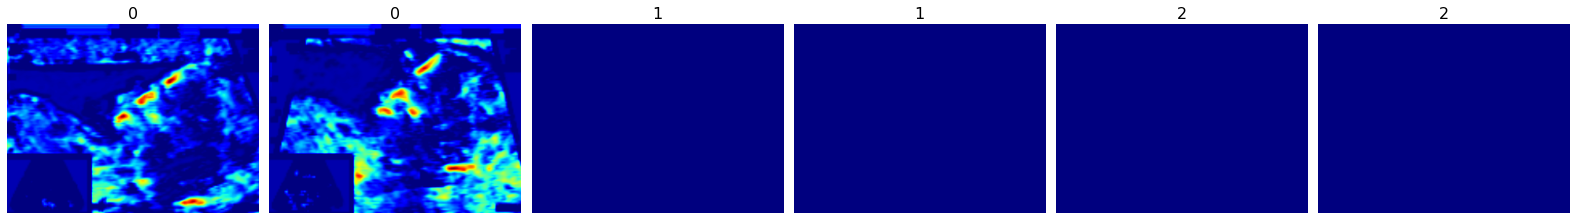

In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

#Create Gradcam object
gradcam = Gradcam(model,model_modifier=model_modifier,clone=False)

#Generate heatmap with GradCAM
cam = gradcam(test_score, test_X, penultimate_layer=-1)
#cam = gradcam(score, X, penultimate_layer=-1)

#Render
f, ax = plt.subplots(nrows=1, ncols=6, figsize=(22, 8))
for i, title in enumerate(test_image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(heatmap, cmap='jet', alpha=1) #overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

# **DL Interpretability: GradCam++**

In [ ]:
from tf_keras_vis.gradcam import GradcamPlusPlus

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create GradCAM++ object and repalce class name to "GradcamPlusPlus"
gradcamplus = GradcamPlusPlus(model,model_modifier,clone=False)

# Generate heatmap with GradCAM
camplus = gradcamplus(score, X, penultimate_layer=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=6, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(camplus[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(heatmap, cmap='jet', alpha=1) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

**NEW IMAGES**

In [ ]:
from tf_keras_vis.gradcam import GradcamPlusPlus

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create GradCAM++ object and repalce class name to "GradcamPlusPlus"
gradcamplus = GradcamPlusPlus(model,model_modifier,clone=False)

# Generate heatmap with GradCAM
camplus = gradcamplus(test_score, test_X, penultimate_layer=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=6, figsize=(22, 8))
for i, title in enumerate(test_image_titles):
    heatmap = np.uint8(cm.jet(camplus[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(heatmap, cmap='jet', alpha=1) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

highlighting a lot the regions with high gradients --> inset box and information at the top --> consistent pattern for every class

What about removing all this information with a mask? --> apply a mask on CRL images to see what happens

# **DL Interpretability: Saliency Maps**

In [ ]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Create Saliency object.
saliency = Saliency(model, model_modifier=model_modifier,clone=False)

# Generate saliency map
saliency_map = saliency(score, X)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=1, ncols=6, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

**NEW IMAGES**

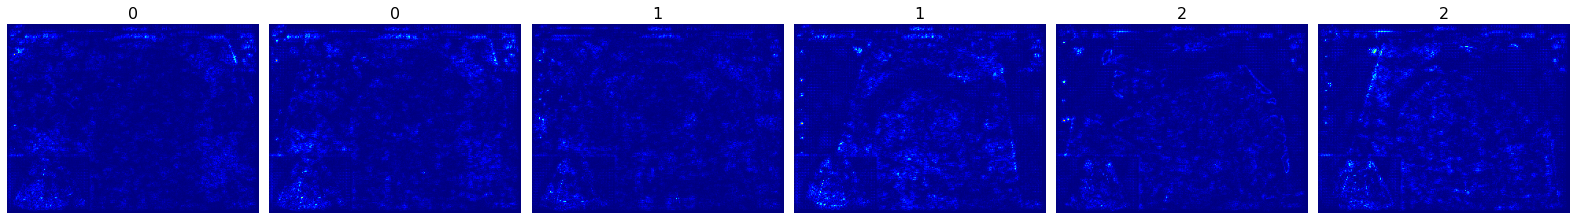

In [ ]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Create Saliency object.
saliency = Saliency(model, model_modifier=model_modifier,clone=False)

# Generate saliency map
saliency_map = saliency(test_score,test_X)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=1, ncols=6, figsize=(22, 8))
for i, title in enumerate(test_image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

# **Overlaying GradCam and GradCam++ with original image**

In [ ]:
##GradCam
fig = plt.figure(figsize=(9, 13))
fig.suptitle('Overlaying results') 

original_image = img1 
mask_image = cam[0] #mask that put on the original image
          
plt.imshow(original_image)
im = plt.imshow(mask_image, cmap='jet', alpha=0.3) # sobreposo la segona imatge amb transparencia de 50% (alpha)
cbar = fig.colorbar(im, shrink=0.99, format='%.6g', pad = 0.01) # modifico el tamany de la barra de color de la imatge
cbar.ax.tick_params(labelsize=6) # modifico el tamany de les lletres de la llegenda del eix
plt.show()

In [ ]:
##GradCam++
fig = plt.figure(figsize=(9, 13))
fig.suptitle('Overlaying results') 

original_image = img1 
mask_image = camplus[0] # selecciono mascara per sobreposar
          
plt.imshow(original_image) #mostro la imatge original
im = plt.imshow(mask_image, cmap='jet', alpha=0.3) # sobreposo la segona imatge amb transparencia de 50% (alpha)
cbar = fig.colorbar(im, shrink=0.99, format='%.6g', pad = 0.01) # modifico el tamany de la barra de color de la imatge
cbar.ax.tick_params(labelsize=6) # modifico el tamany de les lletres de la llegenda del eix
plt.show()

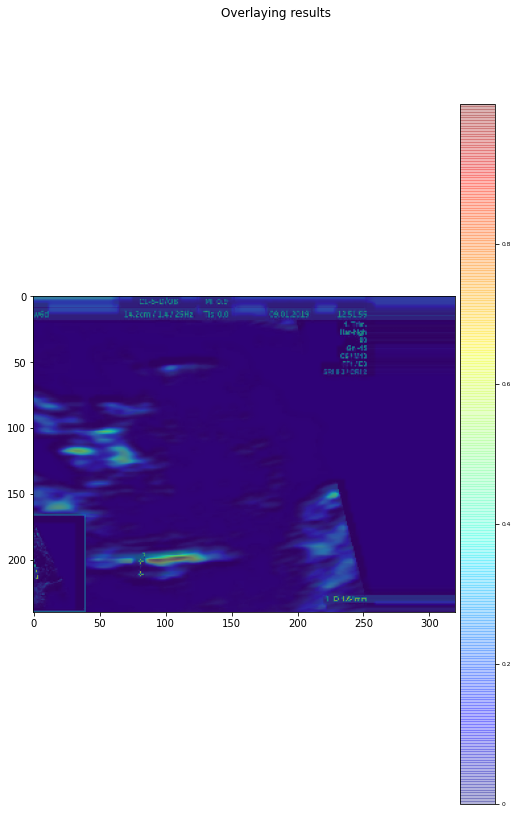

In [ ]:
##GradCam
fig = plt.figure(figsize=(9, 13))
fig.suptitle('Overlaying results') 

original_image = img2 
mask_image = cam[1] # selecciono mascara per sobreposar
          
plt.imshow(original_image) #mostro la imatge original
im = plt.imshow(mask_image, cmap='jet', alpha=0.3) # sobreposo la segona imatge amb transparencia de 50% (alpha)
cbar = fig.colorbar(im, shrink=0.99, format='%.6g', pad = 0.01) # modifico el tamany de la barra de color de la imatge
cbar.ax.tick_params(labelsize=6) # modifico el tamany de les lletres de la llegenda del eix
plt.show()

In [ ]:
##GradCam++
fig = plt.figure(figsize=(9, 13))
fig.suptitle('Overlaying results') 

original_image = img2 
mask_image = camplus[1] # selecciono mascara per sobreposar
          
plt.imshow(original_image) #mostro la imatge original
im = plt.imshow(mask_image, cmap='jet', alpha=0.3) # sobreposo la segona imatge amb transparencia de 50% (alpha)
cbar = fig.colorbar(im, shrink=0.99, format='%.6g', pad = 0.01) # modifico el tamany de la barra de color de la imatge
cbar.ax.tick_params(labelsize=6) # modifico el tamany de les lletres de la llegenda del eix
plt.show()

In [ ]:
##GradCam++
fig = plt.figure(figsize=(9, 13))
fig.suptitle('Overlaying results') 

original_image = img3 ##### CLASS 0
mask_image = camplus[2] # selecciono mascara per sobreposar
          
plt.imshow(original_image) #mostro la imatge original
im = plt.imshow(mask_image, cmap='jet', alpha=0.3) # sobreposo la segona imatge amb transparencia de 50% (alpha)
cbar = fig.colorbar(im, shrink=0.99, format='%.6g', pad = 0.01) # modifico el tamany de la barra de color de la imatge
cbar.ax.tick_params(labelsize=6) # modifico el tamany de les lletres de la llegenda del eix
plt.show()

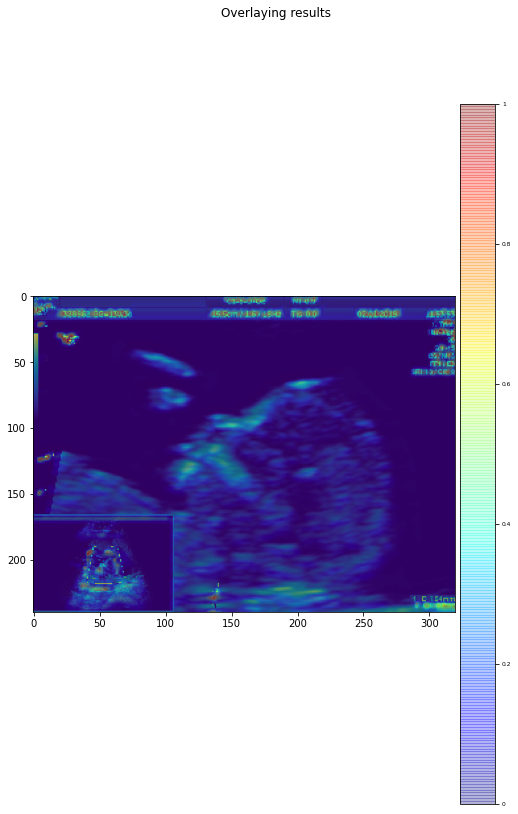

In [ ]:
##GradCam++
fig = plt.figure(figsize=(9, 13))
fig.suptitle('Overlaying results') 

original_image = img5 ########### CLASS 0
mask_image = camplus[4] # selecciono mascara per sobreposar
          
plt.imshow(original_image) #mostro la imatge original
im = plt.imshow(mask_image, cmap='jet', alpha=0.3) # sobreposo la segona imatge amb transparencia de 50% (alpha)
cbar = fig.colorbar(im, shrink=0.99, format='%.6g', pad = 0.01) # modifico el tamany de la barra de color de la imatge
cbar.ax.tick_params(labelsize=6) # modifico el tamany de les lletres de la llegenda del eix
plt.show()

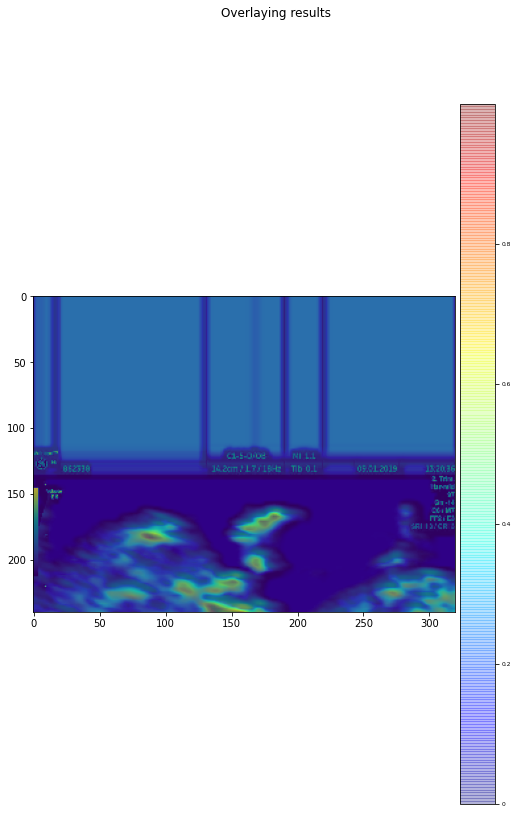

In [ ]:
##GradCam
fig = plt.figure(figsize=(9, 13))
fig.suptitle('Overlaying results') 

original_image = img4 
mask_image = cam[3] # selecciono mascara per sobreposar
          
plt.imshow(original_image) #mostro la imatge original
im = plt.imshow(mask_image, cmap='jet', alpha=0.3) # sobreposo la segona imatge amb transparencia de 50% (alpha)
cbar = fig.colorbar(im, shrink=0.99, format='%.6g', pad = 0.01) # modifico el tamany de la barra de color de la imatge
cbar.ax.tick_params(labelsize=6) # modifico el tamany de les lletres de la llegenda del eix
plt.show()

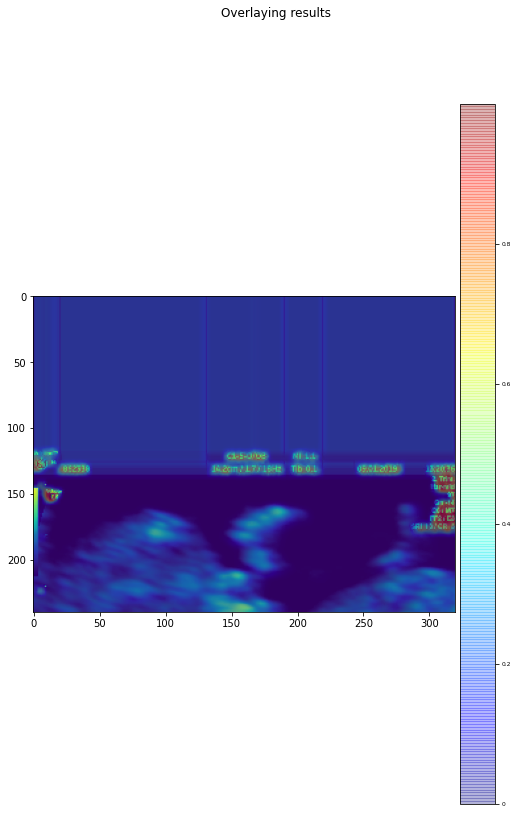

In [ ]:
##GradCam++
fig = plt.figure(figsize=(9, 13))
fig.suptitle('Overlaying results') 

original_image = img4 
mask_image = camplus[3] # selecciono mascara per sobreposar
          
plt.imshow(original_image) #mostro la imatge original
im = plt.imshow(mask_image, cmap='jet', alpha=0.3) # sobreposo la segona imatge amb transparencia de 50% (alpha)
cbar = fig.colorbar(im, shrink=0.99, format='%.6g', pad = 0.01) # modifico el tamany de la barra de color de la imatge
cbar.ax.tick_params(labelsize=6) # modifico el tamany de les lletres de la llegenda del eix
plt.show()

In [ ]:
##GradCam
fig = plt.figure(figsize=(9, 13))
fig.suptitle('Overlaying results') 

original_image = img6 
mask_image = cam[5] # selecciono mascara per sobreposar
          
plt.imshow(original_image) #mostro la imatge original
im = plt.imshow(mask_image, cmap='jet', alpha=0.3) # sobreposo la segona imatge amb transparencia de 50% (alpha)
cbar = fig.colorbar(im, shrink=0.99, format='%.6g', pad = 0.01) # modifico el tamany de la barra de color de la imatge
cbar.ax.tick_params(labelsize=6) # modifico el tamany de les lletres de la llegenda del eix
plt.show()

In [ ]:
##GradCam++
fig = plt.figure(figsize=(9, 13))
fig.suptitle('Overlaying results') 

original_image = img6 
mask_image = camplus[5] # selecciono mascara per sobreposar
          
plt.imshow(original_image) #mostro la imatge original
im = plt.imshow(mask_image, cmap='jet', alpha=0.3) # sobreposo la segona imatge amb transparencia de 50% (alpha)
cbar = fig.colorbar(im, shrink=0.99, format='%.6g', pad = 0.01) # modifico el tamany de la barra de color de la imatge
cbar.ax.tick_params(labelsize=6) # modifico el tamany de les lletres de la llegenda del eix
plt.show()

# **Transfer Learning: VGG16**

In [ ]:
from os import listdir
from os.path import isfile, join
import re
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
import cv2

x = []
y = []

#Class 0: 0-49%
mypath = '/content/drive/MyDrive/Colab Notebooks/Master Thesis/TN_Training/TN_0' # edit with the path to your data
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]

# New size:
w2 = 320
h2 = 240

######## which modifications are necessary (color channels, resizing, gaussian blur) ############
for file in files:
    label = 0
    y.append(label)
    img = cv2.imread(mypath+'/'+file)
    #img = cv2.GaussianBlur(img,(7,7),0)
    img = cv2.resize(img, dsize=(h2, w2), interpolation=cv2.INTER_CUBIC)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #3 dimensions have to be maintained
    
    
    x.append(img)


#Class 1: 50-99%
mypath = '/content/drive/MyDrive/Colab Notebooks/Master Thesis/TN_Training/TN_1' # edit with the path to your data
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]

for file in files:
    label = 1
    y.append(label)
    img = cv2.imread(mypath+'/'+file)
    #img = cv2.GaussianBlur(img1,(7,7),0)
    img = cv2.resize(img, dsize=(h2, w2), interpolation=cv2.INTER_CUBIC)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    x.append(img)


#Class 2: 100%
mypath = '/content/drive/MyDrive/Colab Notebooks/Master Thesis/TN_Training/TN_2' # edit with the path to your data
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]

for file in files:
    label = 2
    y.append(label)
    img = cv2.imread(mypath+'/'+file)
    #img = cv2.GaussianBlur(img1,(7,7),0)
    img = cv2.resize(img, dsize=(h2, w2), interpolation=cv2.INTER_CUBIC)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    x.append(img)


x = np.array(x) #containing the TN images
y = np.array(y) #containing the corresponding labels

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Model / data parameters
num_classes = 3
input_shape = (h2, w2, 3)

# the data, split between train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle= True)

y_test_cm = y_test

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
#x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (853, 320, 240, 3)
853 train samples
366 test samples


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=x_train[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input: normalizing input data
x_train = preprocess_input(x_train) 
x_test = preprocess_input(x_test)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 320, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 320, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 320, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 160, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 160, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 160, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 80, 60, 128)       0     

In [ ]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(90, activation='relu')
dense_layer_2 = layers.Dense(27, activation='relu')
prediction_layer = layers.Dense(3, activation='softmax')


model_vgg = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 10, 7, 512)        14714688  
                                                                 
 flatten_1 (Flatten)         (None, 35840)             0         
                                                                 
 dense_1 (Dense)             (None, 90)                3225690   
                                                                 
 dense_2 (Dense)             (None, 27)                2457      
                                                                 
 dense_3 (Dense)             (None, 3)                 84        
                                                                 
Total params: 17,942,919
Trainable params: 3,228,231
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model_vgg.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

model_vgg.fit(x_train, y_train, epochs=10, validation_split=0.2, batch_size=32, callbacks=[es])

model_vgg.save('/content/drive/MyDrive/Colab Notebooks/Master Thesis/NT models/VGG16') #save the model


Epoch 1/10
22/22 [==============================] - 684s 31s/step - loss: 1.3161 - accuracy: 0.3372 - val_loss: 1.1007 - val_accuracy: 0.3567
Epoch 2/10
22/22 [==============================] - 665s 31s/step - loss: 1.1580 - accuracy: 0.3886 - val_loss: 1.1279 - val_accuracy: 0.3509
Epoch 3/10
22/22 [==============================] - 668s 31s/step - loss: 1.0804 - accuracy: 0.4120 - val_loss: 1.0970 - val_accuracy: 0.3216
Epoch 4/10
22/22 [==============================] - 656s 30s/step - loss: 1.0620 - accuracy: 0.4692 - val_loss: 1.1060 - val_accuracy: 0.2865
Epoch 5/10
22/22 [==============================] - 652s 30s/step - loss: 1.0615 - accuracy: 0.4311 - val_loss: 1.0180 - val_accuracy: 0.6316
Epoch 6/10
22/22 [==============================] - 650s 30s/step - loss: 1.0312 - accuracy: 0.4971 - val_loss: 1.0332 - val_accuracy: 0.4854
Epoch 7/10
22/22 [==============================] - 652s 30s/step - loss: 1.0237 - accuracy: 0.4853 - val_loss: 1.0723 - val_accuracy: 0.3801
Epoch 

In [ ]:
#load the model again
model_vgg = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Master Thesis/NT models/VGG16')

              precision    recall  f1-score   support

           0       0.57      0.99      0.73       128
           1       0.00      0.00      0.00       114
           2       0.57      0.67      0.62       124

    accuracy                           0.57       366
   macro avg       0.38      0.55      0.45       366
weighted avg       0.39      0.57      0.46       366



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


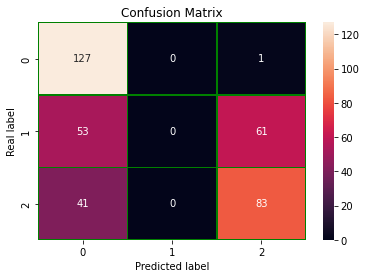

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_test_pred =  np.argmax(model_vgg.predict(x_test), axis=-1)

cm = confusion_matrix(y_test_cm,y_test_pred)

sns.heatmap(cm, annot=True, linewidths=0.5, linecolor='green', fmt='.0f')
plt.xlabel('Predicted label')
plt.ylabel('Real label')
plt.title('Confusion Matrix')


target_names = ['0','1','2']
print(classification_report(y_test_cm, y_test_pred, target_names=target_names))

VGG16 Conclusion: This problem might be too different, imagenet weights don't work for this dataset (fetal ultrasound).

Tuning: https://keras.io/guides/transfer_learning/

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model_vgg.summary()

model_vgg.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

epochs = 10
model_vgg.fit(x_test, y_test, epochs=epochs, validation_data=(x_train, y_train))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 10, 7, 512)        14714688  
                                                                 
 flatten_1 (Flatten)         (None, 35840)             0         
                                                                 
 dense_1 (Dense)             (None, 90)                3225690   
                                                                 
 dense_2 (Dense)             (None, 27)                2457      
                                                                 
 dense_3 (Dense)             (None, 3)                 84        
                                                                 
Total params: 17,942,919
Trainable params: 17,942,919
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
12/12 [========================

# **GradCam++ with VGG16**

In [ ]:
from tf_keras_vis.gradcam import GradcamPlusPlus
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create GradCAM++ object and repalce class name to "GradcamPlusPlus"
gradcamplus = GradcamPlusPlus(model_vgg,model_modifier,clone=False)

# Generate heatmap with GradCAM
camplus = gradcamplus(test_score, test_X, penultimate_layer=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=6, figsize=(12, 4))
for i, title in enumerate(test_image_titles):
    heatmap = np.uint8(cm.jet(camplus[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(heatmap, cmap='jet', alpha=1) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

# **Image Segmentation: K-means**

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read in the image
#image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Master Thesis/Ultrasound_fetus/NT_new/NT_2/TN_2_1/94738055.jpg') #label 2 image
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Master Thesis/Ultrasound_fetus/NT_new/NT_2/TN_2_1/94466490.jpg') #label 2 image
image = cv2.resize(image, dsize=(h, w), interpolation=cv2.INTER_CUBIC)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# reshape the image to a 2D array of pixels and 3 color values (RGB)
pixel_values = image.reshape((-1, 3))
# convert to float
pixel_values = np.float32(pixel_values)

print(pixel_values.shape)

plt.imshow(image)

(76800, 3)


In [ ]:
# define stopping criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.8)

# number of clusters (K)
k = 4
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# convert back to 8 bit values
centers = np.uint8(centers)

# flatten the labels array
labels = labels.flatten()

# convert all pixels to the color of the centroids
#segmented_image = centers[labels.flatten()]
segmented_image = centers[labels]
#segmented_image = labels

# reshape back to the original image dimension
segmented_image = segmented_image.reshape(image.shape)
#segmented_image.reshape(image.shape[0],image.shape[1])
# show the image
plt.imshow(segmented_image)

https://stackoverflow.com/questions/70603461/is-there-any-function-or-method-to-display-clusters-of-mage-after-k-means-image

(76800, 3)


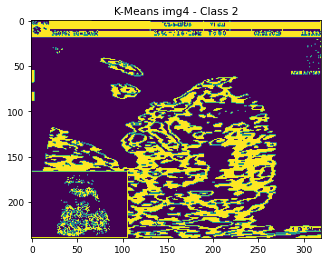

In [ ]:
#CLASS 2 image

image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Master Thesis/Ultrasound_fetus/NT_new/NT_2/TN_2_1/94466490.jpg') #label 2 image
image = cv2.resize(image, dsize=(h, w), interpolation=cv2.INTER_CUBIC)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# reshape the image to a 2D array of pixels and 3 color values (RGB)
pixel_values = image.reshape((-1, 3))
# convert to float
pixel_values = np.float32(pixel_values)

print(pixel_values.shape)

k = 5

retval, labels, centers = cv2.kmeans(pixel_values,k,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

clustered_img = labels.reshape((image.shape[0], image.shape[1]))

clusters_to_0 = [1,3,4]

for c in clusters_to_0:
    clustered_img[clustered_img == c] = -1

clustered_img[clustered_img!=-1] = 1
clustered_img[clustered_img==-1] = 0

clustered_img
plt.imshow(clustered_img)
plt.title('K-Means img4 - Class 2')
plt.show()

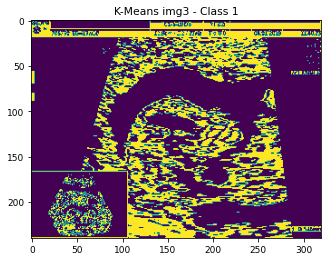

In [ ]:
#CLASS 1 image

image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Master Thesis/Ultrasound_fetus/NT_new/NT_1/TN_1_1/94589218.jpg') #label 2 image
image = cv2.resize(image, dsize=(h, w), interpolation=cv2.INTER_CUBIC)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# reshape the image to a 2D array of pixels and 3 color values (RGB)
pixel_values = image.reshape((-1, 3))
# convert to float
pixel_values = np.float32(pixel_values)

# define stopping criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.8)

k = 5

retval, labels, centers = cv2.kmeans(pixel_values,k,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

clustered_img = labels.reshape((image.shape[0], image.shape[1]))

clusters_to_0 = [1,3,4]

for c in clusters_to_0:
    clustered_img[clustered_img == c] = -1

clustered_img[clustered_img!=-1] = 1
clustered_img[clustered_img==-1] = 0

clustered_img
plt.imshow(clustered_img)
plt.title('K-Means img3 - Class 1')
plt.show()

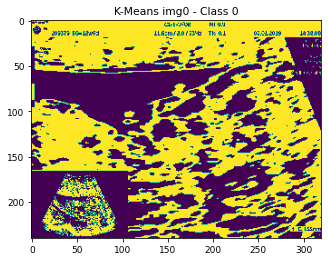

In [ ]:
#CLASS 0 image

image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Master Thesis/Ultrasound_fetus/NT_new/NT_0/TN_0_1/94476745.jpg') #label 0 image
image = cv2.resize(image, dsize=(h, w), interpolation=cv2.INTER_CUBIC)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# reshape the image to a 2D array of pixels and 3 color values (RGB)
pixel_values = image.reshape((-1, 3))
# convert to float
pixel_values = np.float32(pixel_values)

# define stopping criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.8)

k = 5

retval, labels, centers = cv2.kmeans(pixel_values,k,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

clustered_img = labels.reshape((image.shape[0], image.shape[1]))

clusters_to_0 = [1,3,4]

for c in clusters_to_0:
    clustered_img[clustered_img == c] = -1

clustered_img[clustered_img!=-1] = 1
clustered_img[clustered_img==-1] = 0

clustered_img
plt.imshow(clustered_img)
plt.title('K-Means img0 - Class 0')
plt.show()

# **Image Segmentation: Multi-otsu**

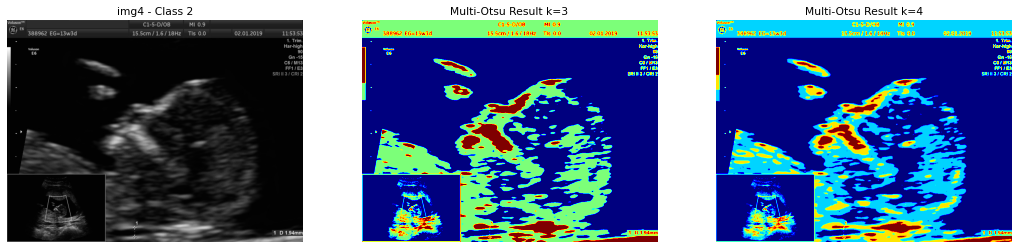

In [ ]:
#Multi-Otsu - CLASS 2 IMAGE

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data
from skimage.filters import threshold_multiotsu

# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 9

# The input image.
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Master Thesis/Ultrasound_fetus/NT_new/NT_2/TN_2_1/94466490.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_multiotsu(image, classes=3)
thresholds2 = threshold_multiotsu(image, classes=4)

# Using the threshold values, we generate the three regions.
regions = np.digitize(image, bins=thresholds)
regions2 = np.digitize(image, bins=thresholds2)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5.5))

# Plotting the original image.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('img4 - Class 2')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
#ax[1].hist(image.ravel(), bins=255)
#ax[1].set_title('Histogram with thresholds k=3')
#for thresh in thresholds:
    #ax[1].axvline(thresh, color='r')

# Plotting the first Multi Otsu result.
ax[1].imshow(regions, cmap='jet')
ax[1].set_title('Multi-Otsu Result k=3')
ax[1].axis('off')

# Plotting the second Multi Otsu result.
ax[2].imshow(regions2, cmap='jet')
ax[2].set_title('Multi-Otsu Result k=4')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()

In [ ]:
#Multi-Otsu - CLASS 1 IMAGE

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data
from skimage.filters import threshold_multiotsu

# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 9

# The input image.
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Master Thesis/Ultrasound_fetus/NT_new/NT_1/TN_1_1/94589218.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_multiotsu(image, classes=3)
thresholds2 = threshold_multiotsu(image, classes=4)

# Using the threshold values, we generate the three regions.
regions = np.digitize(image, bins=thresholds)
regions2 = np.digitize(image, bins=thresholds2)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5.5))

# Plotting the original image.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('img3 - Class 1')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
#ax[1].hist(image.ravel(), bins=255)
#ax[1].set_title('Histogram with thresholds k=3')
#for thresh in thresholds:
   # ax[1].axvline(thresh, color='r')

# Plotting the first Multi Otsu result.
ax[1].imshow(regions, cmap='jet')
ax[1].set_title('Multi-Otsu Result k=3')
ax[1].axis('off')

# Plotting the second Multi Otsu result.
ax[2].imshow(regions2, cmap='jet')
ax[2].set_title('Multi-Otsu Result k=4')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()

In [ ]:
#Multi-Otsu - CLASS 0 IMAGE

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data
from skimage.filters import threshold_multiotsu

# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 9

# The input image.
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Master Thesis/Ultrasound_fetus/NT_new/NT_0/TN_0_1/94476745.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_multiotsu(image, classes=3)
thresholds2 = threshold_multiotsu(image, classes=4)

# Using the threshold values, we generate the three regions.
regions = np.digitize(image, bins=thresholds)
regions2 = np.digitize(image, bins=thresholds2)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5.5))

# Plotting the original image.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('img0 - Class 0')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
#ax[1].hist(image.ravel(), bins=255)
#ax[1].set_title('Histogram with thresholds k=3')
#for thresh in thresholds:
   # ax[1].axvline(thresh, color='r')

# Plotting the first Multi Otsu result.
ax[1].imshow(regions, cmap='jet')
ax[1].set_title('Multi-Otsu Result k=3')
ax[1].axis('off')

# Plotting the second Multi Otsu result.
ax[2].imshow(regions2, cmap='jet')
ax[2].set_title('Multi-Otsu Result k=4')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()